## learning-AI : anomaly detection using diffusion model on number dataset
### number dataset을 통한 diffusion 모델의 anomaly detection 이해

<br>

- **임규연 (lky473736)**
- 2025.02.04.에 문서 작성
- **dataset** : number dataset (직접 만듦)
- **Reference**
    - https://www.youtube.com/watch?v=rjp2RH76e50
    - https://www.youtube.com/watch?v=QlccSe3giG0
    - https://github.com/JuliaWolleb/diffusion-anomaly

------



### <span id='dl'><mark>diffusion model과 anomaly detection</mark></span>

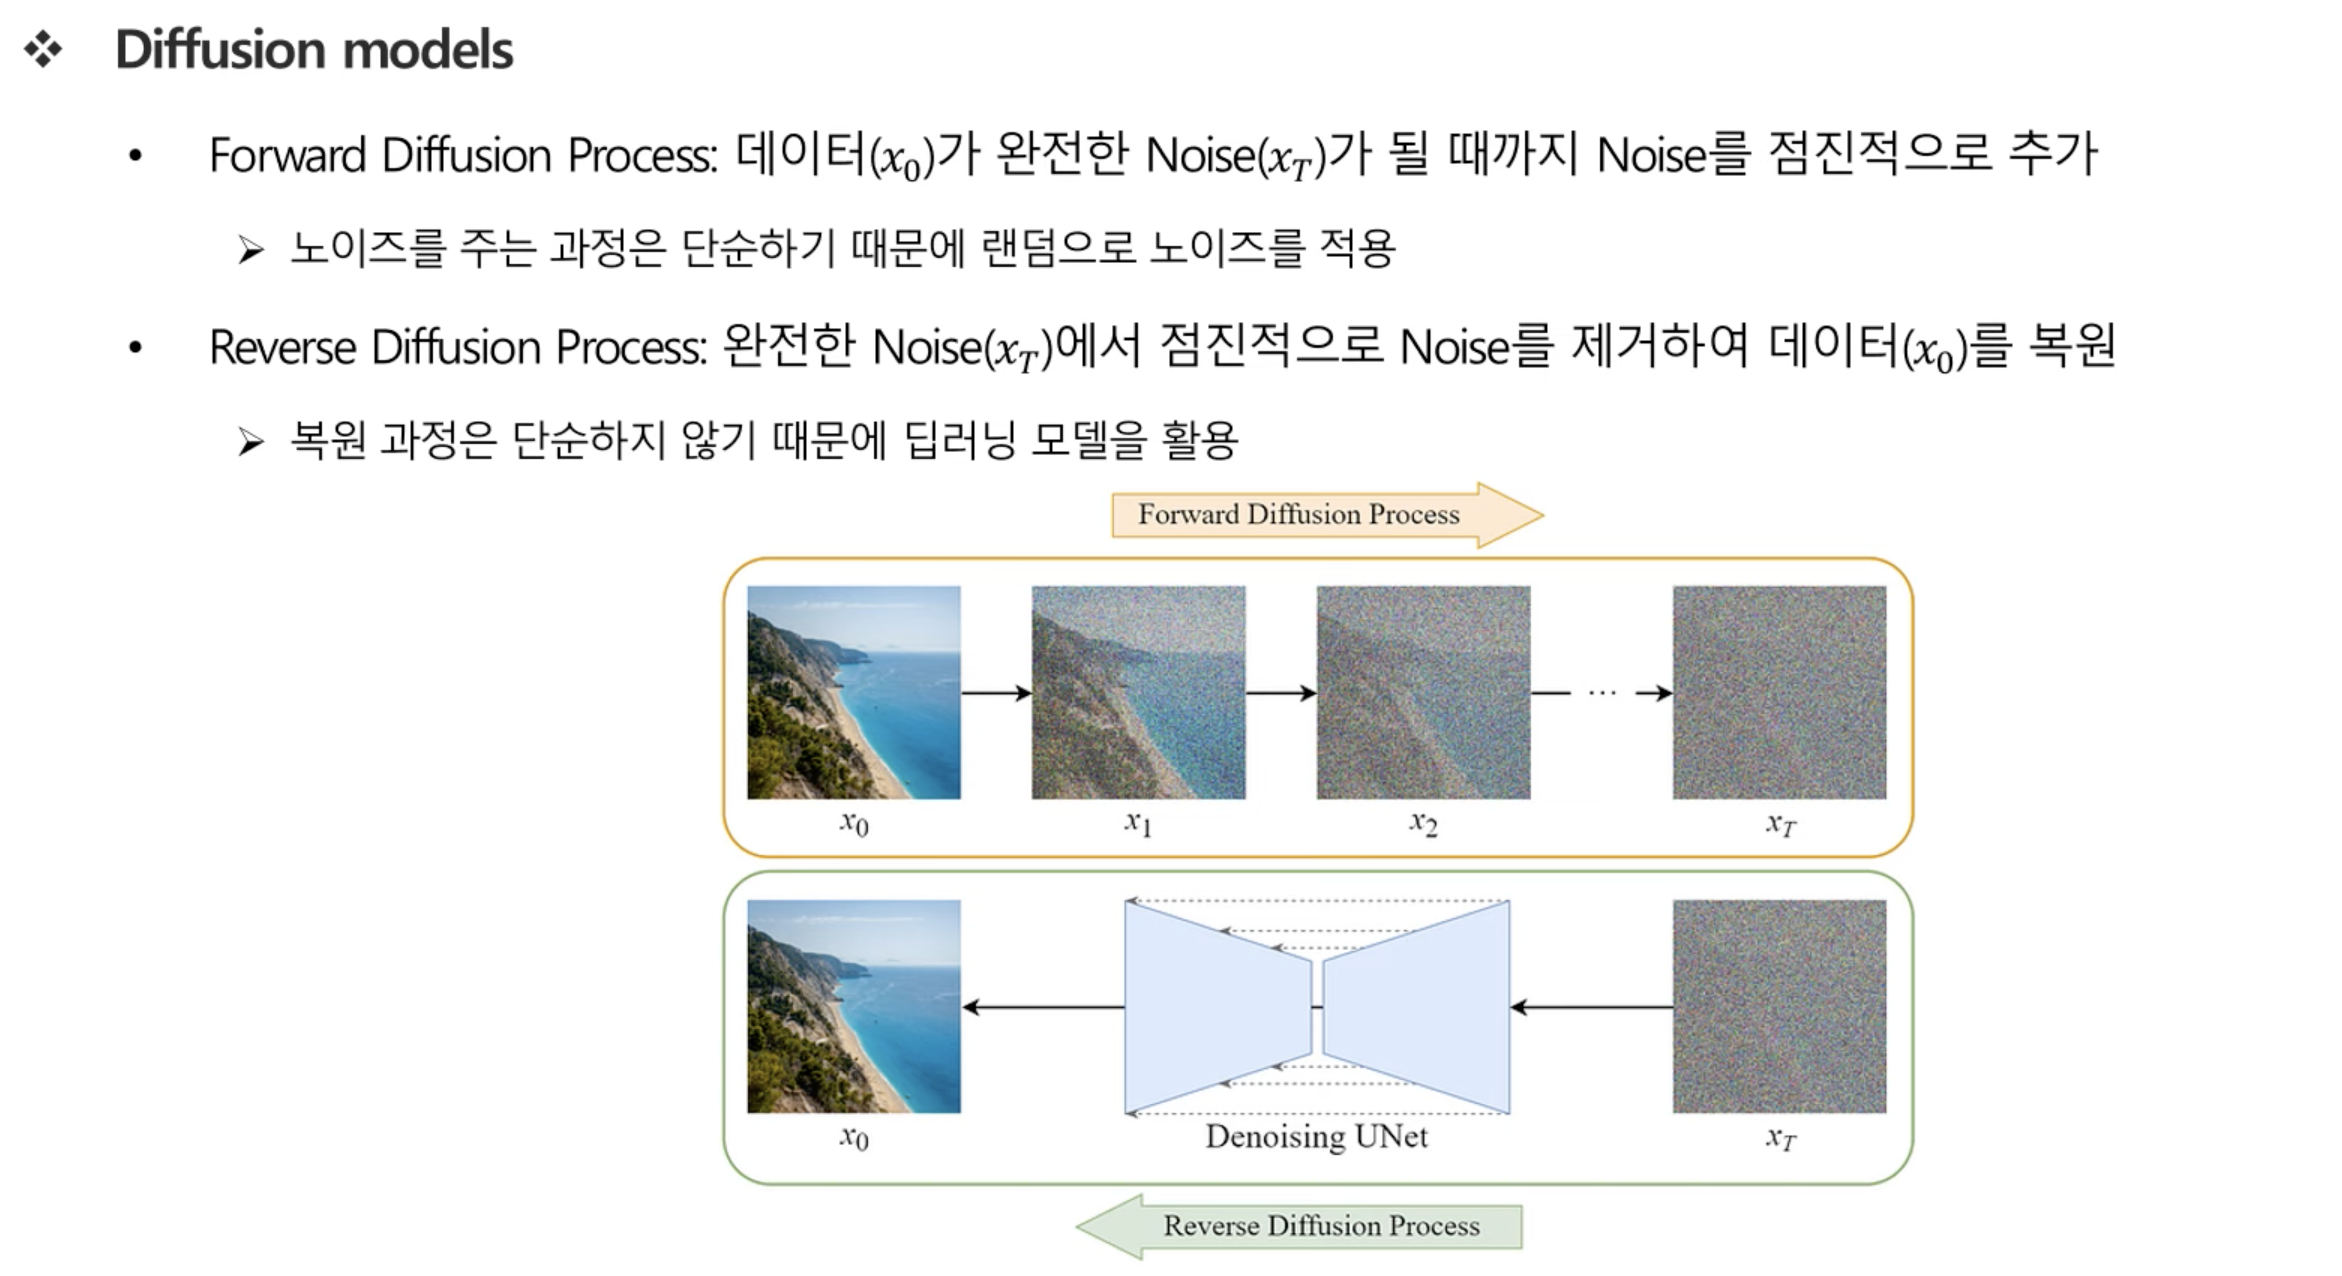


- 우리가 강아지 사진을 가지고 있다고 해보자. 이 사진에 조금씩 노이즈를 추가하면 처음엔 살짝 흐릿해지고, 더 추가하면 더 흐릿해지고, 계속 이렇게 하다 보면 결국에는 완전히 뿌연 노이즈만 남게 된다. **forward diffusion**이라 한다.
- 이 과정을 거꾸로 돌릴 수 있도록 모델을 학습시킬 수 있다. 즉, 완전히 뿌연 노이즈에서 시작해서 조금씩 노이즈를 제거하면서 원래의 강아지 사진을 복원하는 과정 말이다. 이걸 **reverse diffusion**이라 한다.

anomaly detection에서는, 먼저 정상 데이터만을 학습한다. 그러면 모델은 "정상적인" 패턴에서 노이즈를 제거하는 방법만 알게 될 것이다. 나중에 이상치가 포함된 데이터가 들어오면 모델은 정상적인 패턴으로만 복원하려고 시도할 것이다. 그러면 원본과 복원된 데이터 사이의 차이 (reconstruction error)가 발생할 것이고, 그것이 큰게 anomaly가 된다.

즉, 디퓨전 모델의 핵심은 "점진적으로 노이즈를 추가했다가 다시 제거하는 과정을 학습"하는 거라고 생각한다. 모델이 데이터의 본질적인 특성을 더 잘 학습할 수 있기 때문에, 한 번에 큰 변화를 주는 게 아니라, 아주 작은 변화들을 여러 단계에 걸쳐 학습하는 것이다.

In [21]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

class DiffusionModel(tf.keras.Model):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        
        # Encoder with deeper architecture
        self.encoder = tf.keras.Sequential([
            # First conv block
            tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            
            # Second conv block with increased channels
            tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            
            # Third conv block with max channels
            tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
        ])
        
        # Decoder with symmetric architecture
        self.decoder = tf.keras.Sequential([
            # First deconv block
            tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(256, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            
            # Second deconv block
            tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(128, 3, padding='same', activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            
            # Final conv block for output
            tf.keras.layers.Conv1D(64, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(32, 3, padding='same', activation='relu'),
            tf.keras.layers.Conv1D(1, 3, padding='same', activation=None)
        ])
    
    def call(self, x, training=False):
        encoded = self.encoder(x, training=training)
        decoded = self.decoder(encoded, training=training)
        return decoded

In [ ]:
def forward_diffusion(x, noise_level=0.2):
    noise = tf.random.normal(shape=tf.shape(x)) * noise_level
    return x + noise # 그니깐 여기서 forward diffusion을 수행한다. noise를 추가한다는 것

In [22]:
def create_data(n_samples=1000, seq_length=50, is_train=True):
    t = np.linspace(0, 10, seq_length)
    data = []
    anomaly_positions = []  # 이상치 위치 기록 (나중에 시각화할거임)
    
    if is_train: # <- train
        # 학습 데이터는 모두 정상 데이터
        for _ in range(n_samples):
            freq = np.random.uniform(0.5, 2.0)
            signal = np.sin(freq * t)
            data.append(signal)
    else: # <- test
        n_anomalies = 10  # 이상치가 있는 시계열의 수
        anomaly_indices = np.random.choice(n_samples, n_anomalies, replace=False)
        
        for i in range(n_samples):
            freq = np.random.uniform(0.5, 2.0)
            signal = np.sin(freq * t)
            
            if i in anomaly_indices:
                # 각 시계열에 1~3개의 이상치 추가함 (중간중간에 이상치 넣기)
                n_spikes = np.random.randint(1, 4)
                spike_positions = np.random.choice(seq_length, n_spikes, replace=False)
                for pos in spike_positions:
                    signal[pos] += np.random.choice([-3.0, 3.0])  
                    # 이상치는 (-3~3) 사이의 값을 더하기
                    anomaly_positions.append((i, pos))
            
            data.append(signal)
    
    return np.array(data)[..., np.newaxis], anomaly_positions

In [23]:
def anomaly_score(x_real, x_recon):
    return tf.reduce_mean(tf.abs(x_real - x_recon), axis=1)

In [24]:
train_data, _ = create_data(n_samples=500, is_train=True)  # 더 많은 학습 데이터
test_data, anomaly_positions = create_data(n_samples=250, is_train=False)
    
train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
test_data = tf.convert_to_tensor(test_data, dtype=tf.float32)

print (train_data.shape)
print (test_data.shape)

(500, 50, 1)
(250, 50, 1)


In [27]:
model = DiffusionModel()

initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate)

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate_schedule)

In [28]:
model.summary()

Model: "diffusion_model_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_57 (Sequential)      │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_58 (Sequential)      │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
batch_size = 32
epochs = 100  
best_loss = float('inf')

for epoch in range(epochs):
    indices = tf.random.shuffle(tf.range(len(train_data)))
    shuffled_data = tf.gather(train_data, indices)

    total_loss = 0
    n_batches = len(train_data) // batch_size

    for i in range(n_batches):
        batch_data = shuffled_data[i*batch_size:(i+1)*batch_size]

        with tf.GradientTape() as tape:
            noisy = forward_diffusion(batch_data, noise_level=0.25)  # 노이즈 레벨 증가
            reconstructed = model(noisy, training=True)
            loss = tf.reduce_mean(tf.square(reconstructed - batch_data))

        grads = tape.gradient(loss, model.trainable_variables)
        grads, _ = tf.clip_by_global_norm(grads, clip_norm=1.0)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        total_loss += loss

    avg_loss = total_loss / n_batches

    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")

Epoch 0, Loss: 0.3960
Epoch 5, Loss: 0.0139
Epoch 10, Loss: 0.0106
Epoch 15, Loss: 0.0097
Epoch 20, Loss: 0.0086
Epoch 25, Loss: 0.0079
Epoch 30, Loss: 0.0073
Epoch 35, Loss: 0.0072
Epoch 40, Loss: 0.0068
Epoch 45, Loss: 0.0067
Epoch 50, Loss: 0.0065
Epoch 55, Loss: 0.0070
Epoch 60, Loss: 0.0061
Epoch 65, Loss: 0.0063
Epoch 70, Loss: 0.0056
Epoch 75, Loss: 0.0056
Epoch 80, Loss: 0.0055
Epoch 85, Loss: 0.0061
Epoch 90, Loss: 0.0051
Epoch 95, Loss: 0.0061


In [37]:
test_reconstructed = model(test_data, training=False)
anomaly_scores = anomaly_score(test_data, test_reconstructed)

In [38]:
threshold = tf.reduce_mean(anomaly_scores) + 2 * tf.math.reduce_std(anomaly_scores)

In [39]:
detected_anomalies = anomaly_scores > threshold

print("\nAnomaly Detection Results :")
print(f"Number of detected anomalies: {tf.reduce_sum(tf.cast(detected_anomalies, tf.int32))}")


Anomaly Detection Results:
Number of detected anomalies: 10


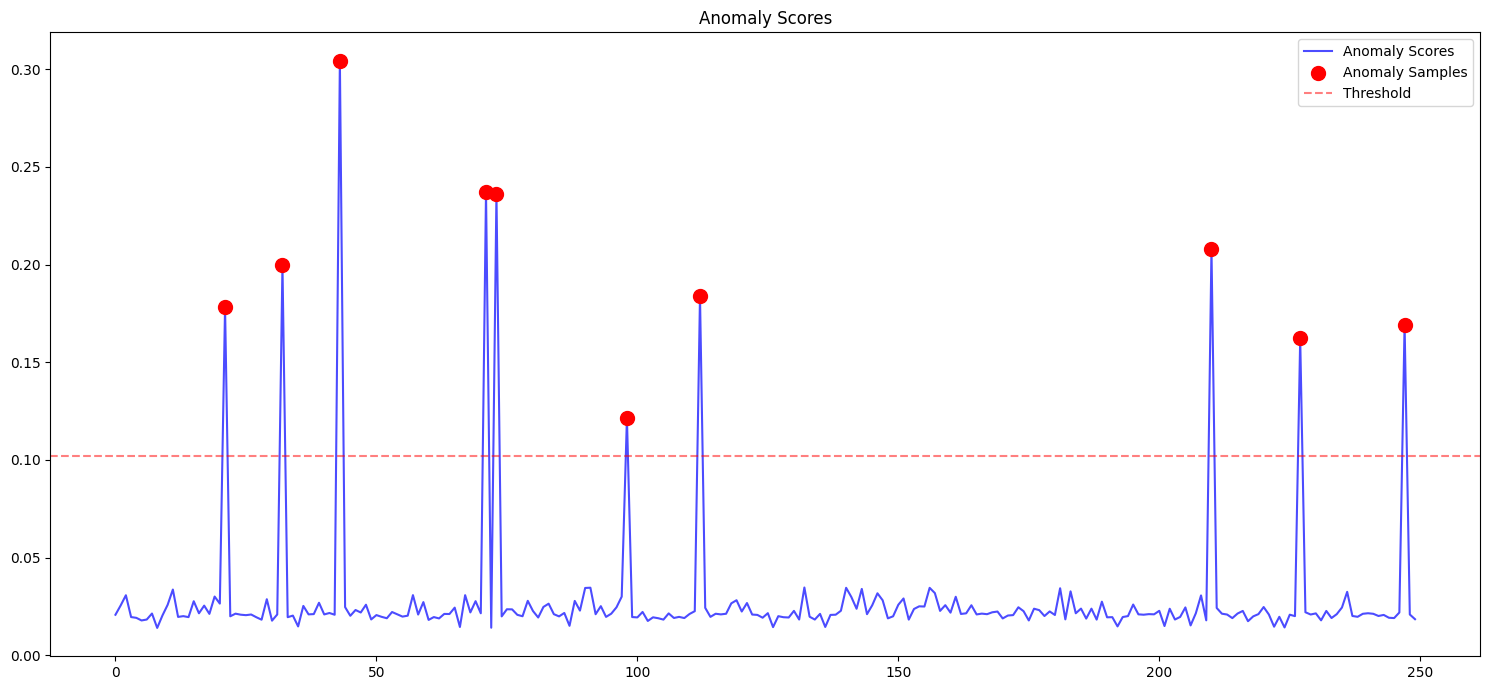

In [40]:
plt.figure(figsize=(15, 7))

plt.plot(anomaly_scores.numpy(), 'b-', label='Anomaly Scores', alpha=0.7)

anomaly_indices = list(set([idx for idx, _ in anomaly_positions]))
plt.scatter(anomaly_indices, 
           [anomaly_scores[i].numpy() for i in anomaly_indices],
           color='red', s=100, label='Anomaly Samples', zorder=5)

threshold = tf.reduce_mean(anomaly_scores) + 2 * tf.math.reduce_std(anomaly_scores)
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold', alpha=0.5)
plt.title('Anomaly Scores')
plt.legend()

plt.tight_layout()
plt.show()